# Which forecasts are reproducible using the current and stationary (copied 2022-01-25) version of the model executable located at `/home/599/ds0092/src/mom_cafe`?

In [1]:
import os
import re
import glob

import xarray as xr

import matplotlib.pyplot as plt

### Get list for forecasts in the order they were run

In [2]:
fms_path = "../../data/raw/c5-d60-pX-f6-????????/c5-d60-pX-f6-????????-base/*/*/*/CAFE/forecasts/f6/WIP/c5-d60-pX-f6-????????/MOM/fms_CM2M.x"

order = glob.glob(fms_path)
order.sort(key=os.path.getmtime)

forecast_re = re.compile(r"c5-d60-pX-f6-\d\d\d\d\d\d\d\d")
forecasts = [forecast_re.search(f).group() for f in order]

### See if the results are reproducible

In [3]:
orig_path = "/g/data/xv83/dcfp/CAFE-f6/"
rerun_path = "../../data/raw/"

collection = "ocean_month.zarr.zip"
variable = "sst"

In [ ]:
out = []
for forecast in forecasts:
    try:
        rerun = xr.open_dataset(
            f"{rerun_path}/{forecast}-reproducibility_test/ZARR/{collection}", 
            engine="zarr", chunks={})
        rerun = rerun[variable].sel(ensemble=1)
        
        orig = xr.open_dataset(
            f"{orig_path}/{forecast}/{collection}", 
            engine="zarr", chunks={})
        orig = orig[variable].sel(ensemble=1)
        
        repro = orig.equals(rerun)
        if repro:
            # out.append(f"{forecast}: yes")
            out.append("\\cmark & ")
        else:
            # out.append(f"{forecast}: no")
            out.append("\\xmark & ")
        
    except FileNotFoundError:
        if forecast[13:19] in [f"{y}05" for y in range(1981,1990)]:
            print(f"{forecast} uses current executable")
            
            # out.append(f"{forecast}: yes")
            out.append("\\cmark & ")
        else:
            print(f"{forecast} is not yet available")

            # out.append(f"{forecast}: -")
            out.append("- & ")
        
print("".join(out)[:-2])

### Why is 19951101 different?

In [5]:
forecast = "c5-d60-pX-f6-19951101"

rerun = xr.open_dataset(
    f"{rerun_path}/{forecast}-reproducibility_test/ZARR/{collection}", 
    engine="zarr", chunks={})
rerun = rerun[variable].sel(ensemble=1)

orig = xr.open_dataset(
    f"{orig_path}/{forecast}/{collection}", 
    engine="zarr", chunks={})
orig = orig[variable].sel(ensemble=1)

In [6]:
orig_gbl = orig.weighted(orig["area_t"]).mean(["xt_ocean", "yt_ocean"]).compute()
rerun_gbl = rerun.weighted(rerun["area_t"]).mean(["xt_ocean", "yt_ocean"]).compute()

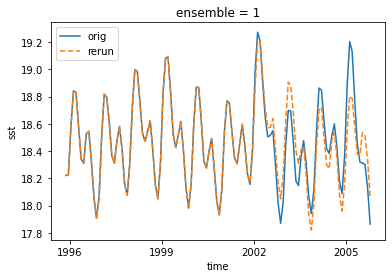

In [7]:
orig_gbl.plot(label="orig")
rerun_gbl.plot(linestyle='--', label="rerun")
plt.legend()

In [8]:
diff = rerun - orig

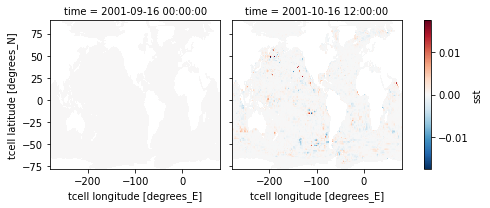

In [9]:
diff.isel(time=[70, 71]).plot(col="time")

### Something changes at timestep = 71 and they start to differ...

### It's not clear how/why these are different. Both forecasts were run with the same executable and timestep. Additionally, the number of timesteps run for each forecast (as diagnosed from the mom*.out files) is the same, indicating that both forecasts were run as a single CYCLE...

### So how does something change part-way through a forecast?...